In [4]:
import json
import psycopg2
import time
import pandas as pd
from datetime import datetime
import numpy as np
import math
import pickle
import os
import pandas.io.sql as sqlio
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [5]:
conn = psycopg2.connect(
    host='shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com',
    port='5432',
    user='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c',
    password='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_password',
    database='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_db'
)

In [6]:
q='''SELECT created_at as created, id as order_iD, total_price as order_amount, email as user_id from orders WHERE
cancelled_at is NULL;
'''
e=pd.read_sql(q,conn)

In [7]:
#e=e[e['created']<='2023/05/29']
#e=e[e['created']>='2023/11/29']
#e.info()

In [8]:
e['WeekCount']=e['created'].dt.strftime('%Y-w%U')

In [9]:
e=e.sort_values('created')
WeekList=e['WeekCount'].unique()
List=WeekList

In [10]:
e["New"] = 0
e['TrxnRank'] = e.groupby('user_id')['created'].rank(method='first')
e.loc[e['TrxnRank']==1,'New'] = 1

In [11]:
e['OrderDate']=e['created'].dt.date
e['OrderDate']=pd.to_datetime(e['OrderDate'])
e['DeltaDaysinOrders']=(e.groupby('user_id').OrderDate.shift() - e.OrderDate).dt.days.abs()
e['DeltaOrderValues']=(e.groupby('user_id').order_amount.shift() - e.order_amount)

In [12]:
k=e
k['OrderDate']=k['created'].dt.date
k['OrderDate']=pd.to_datetime(k['OrderDate'])
WeekList=k['WeekCount'].unique()

In [13]:
e

,created,order_id,order_amount,user_id,WeekCount,New,TrxnRank,OrderDate,DeltaDaysinOrders,DeltaOrderValues
70682,2020-09-12 14:26:27,2418150342794,1.0,devansh.bajaj@cred.club,2020-w36,1,1.0,2020-09-12,NaN,NaN
70681,2020-09-12 14:28:21,2418151194762,1.0,devansh.bajaj@cred.club,2020-w36,0,2.0,2020-09-12,0.0,0.00
70680,2020-09-12 14:37:33,2418154733706,1.0,devansh.bajaj@cred.club,2020-w36,0,3.0,2020-09-12,0.0,0.00
70679,2020-09-12 14:39:33,2418155159690,1.0,devansh.bajaj@cred.club,2020-w36,0,4.0,2020-09-12,0.0,0.00
70678,2020-09-12 17:28:12,2418214437002,1.0,devansh.bajaj@cred.club,2020-w36,0,5.0,2020-09-12,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...
70687,2023-12-13 11:40:38,5348176101514,597.0,silviya2511@gmail.com,2023-w50,1,1.0,2023-12-13,NaN,NaN
70686,2023-12-13 11:44:43,5348177805450,398.0,silviya2511@gmail.com,2023-w50,0,2.0,2023-12-13,0.0,199.00
70685,2023-12-13 11:51:48,5348181115018,3525.0,aarohibakeri@hotmail.com,2023-w50,0,9.0,2023-12-13,140.0,-2477.75
70684,2023-12-13 11:59:28,5348185243786,2760.0,per@smedegaard.info,2023-w50,1,1.0,2023-12-13,NaN,NaN


In [14]:
e['WeekCount'].value_counts().tail(50)

e['OrderDate']=e['created'].dt.date
e['OrderDate']=pd.to_datetime(k['OrderDate'])

x1=e.groupby('user_id').agg(
          LastDate=pd.NamedAgg(column='OrderDate', aggfunc= lambda x: x.nlargest(1).min()),
          FirstDate=pd.NamedAgg(column='OrderDate', aggfunc='min'),
          Frequency=pd.NamedAgg(column='order_id', aggfunc='nunique'),
          AOV=pd.NamedAgg(column='order_amount', aggfunc='mean'),
          OrderValue=pd.NamedAgg(column='order_amount', aggfunc='sum'),
          MeanDaysDelta=pd.NamedAgg(column='DeltaDaysinOrders', aggfunc='mean'),
          MeanOVDelta=pd.NamedAgg(column='DeltaOrderValues', aggfunc='mean'),
          New=pd.NamedAgg(column='New',aggfunc='mean')
      ).reset_index()
globalmaxdate=e['OrderDate'].max()
x1['Recency']=globalmaxdate-x1['LastDate']
x1['Recency']=x1['Recency'].dt.days.abs()
x1['ActivatedQuater']=x1['FirstDate'].dt.to_period('Q')
x1['MaturityAge']=np.nan
x1.loc[x1['Frequency']>1,"MaturityAge"]=(x1['LastDate']-x1['FirstDate']).dt.days.abs()
x1['MeanDaysDelta']=x1['MeanDaysDelta'].fillna(0)
x1['MeanOVDelta']=x1['MeanOVDelta'].fillna(0)

r_labels, f_labels,AOV_labels, m_labels,DelAOV_labels = range(4, 0, -1), range(1,5), range(1,5),range(1,5),range(1,5)
x1['r_score'] = x1['Recency'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = r_labels)).astype('int64')
x1['f2d_score'] = x1['Frequency'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = f_labels)).astype('int64')
x1['AOV_score'] = x1['AOV'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = AOV_labels)).astype('int64')
x1['m_score']=0
x1.loc[x1['MaturityAge'].notnull(),'m_score']= x1.loc[x1['MaturityAge'].notnull()]['MaturityAge'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = m_labels)).astype('int64')
x1['DelAOV'] = x1['MeanOVDelta'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = DelAOV_labels)).astype('int64')
x1['SumScore'] = x1['r_score'] + x1['f2d_score'] + x1['m_score'] + x1['AOV_score']+ x1['DelAOV']

# def CohortLables_1(df):
#   if (df['New']==1 and df['AOV_score']>2):
#     return 'New&High Value'
#   elif (df['New']==1 and df['AOV_score']<=2):
#     return 'New&Low Value'
#   elif (df['New']<1 and df['AOV_score']<=2):
#     return 'Returning&Low Value'
#   else:
#     return 'Returning&High Value'

# def CohortLables_2(df):
#   if ((df['SumScore'] >= 18) and (df['Frequency']>1)):
#       return 'Champions'
#   elif ((df['m_score'] <=1) and (df['SumScore'] >= 10)and (df['SumScore'] < 18) and (df['r_score'] >1)):
#       return 'New&Potential'
#   elif ((df['m_score'] >1) and (df['SumScore'] >= 14)and (df['SumScore'] < 18)and (df['r_score'] >1)):
#       return 'Mature&Loyal'
#   elif ((df['m_score'] >1) and (df['SumScore'] >= 10)and (df['SumScore'] < 14)and (df['r_score'] >1)):
#       return 'Mature&Slow'
#   elif ((df['m_score'] <=1) and (df['SumScore'] >= 5)and (df['SumScore'] < 10)and (df['r_score'] >1)):
#       return 'New&Slow'
#   elif ((df['m_score'] >1) and (df['SumScore'] >= 5)and (df['SumScore'] < 10)and (df['r_score'] >1)):
#       return 'Mature&ChurnRisk'
#   else:
#       return 'Churned'

def CohortLables_3(df):
    if ((df['Frequency']==1) & (df['r_score']>2)):
        return "New"
    elif ((df['Frequency'] == 1) & (df['r_score'] <= 2)):
        return 'Churned (Single Use Only)'
    elif ((df['Frequency'] > 1) & (df['m_score'] < 3) & (df['r_score'] >2)):
        return 'Recent & Loyals'
    elif ((df['Frequency'] > 1) & (df['m_score'] >=3) & (df['r_score'] > 2)):
        return 'Champions'
    else:
        return 'Churned (Repeat Use)'

In [15]:
count_customer = e['user_id'].nunique()
maxDate = e.OrderDate.max()
minDate = e.OrderDate.min()
no_of_days = maxDate - minDate
no_of_days.days
x1['CohortLabel'] = x1.apply(CohortLables_3, axis=1)
# if (count_customer<500 or no_of_days.days < 180):
#   x1['CohortLabel'] = x1.apply(CohortLables_1, axis=1)
# else:
#   x1['CohortLabel'] = x1.apply(CohortLables_2, axis=1)

In [16]:
segstats=x1.groupby(
  'CohortLabel'
).agg(
      Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
      Recency=pd.NamedAgg(column='Recency', aggfunc='mean'),
      Frequency=pd.NamedAgg(column='Frequency', aggfunc='mean'),
      AOV=pd.NamedAgg(column='AOV', aggfunc='mean'),
      OrderValue=pd.NamedAgg(column='OrderValue', aggfunc='sum'),
      #MeanDaysDelta=pd.NamedAgg(column='MeanDaysDelta', aggfunc='mean'),
      #MeanOVDelta=pd.NamedAgg(column='MeanOVDelta', aggfunc='mean'),
      #FrequencyperDeltaDays=pd.NamedAgg(column='FrequencyperDeltaDays', aggfunc='mean'),
    Maturity=pd.NamedAgg(column='MaturityAge', aggfunc='mean'),
    OrderCount=pd.NamedAgg(column='Frequency', aggfunc='sum'),
).reset_index()
segstats['OrderValueMix']=segstats['OrderValue']/segstats['OrderValue'].sum()
segstats['UsersMix']=segstats['Users']/segstats['Users'].sum()
segstats['AOV_Contribution']=segstats['OrderValue']/segstats['OrderCount'].sum()
segstats['OrderCountMix']=segstats['OrderCount']/segstats['OrderCount'].sum()

In [17]:
segstats

,CohortLabel,Users,Recency,Frequency,AOV,OrderValue,Maturity,OrderCount,OrderValueMix,UsersMix,AOV_Contribution,OrderCountMix
0,Champions,2618,96.686402,4.271199,827.097509,9628134.85,326.006494,11182,0.214228,0.059878,134.789305,0.156543
1,Churned (Repeat Use),3439,505.219831,5.690317,875.678830,12675789.76,158.935156,19569,0.282040,0.078656,177.455023,0.273957
2,Churned (Single Use Only),18422,541.330203,1.000000,721.637559,13294007.12,NaN,18422,0.295795,0.421344,186.109772,0.257899
3,New,16889,97.509089,1.000000,404.710356,6835153.20,NaN,16889,0.152084,0.386282,95.688891,0.236438
4,Recent & Loyals,2354,84.382328,2.280799,466.487498,2510220.50,24.358539,5369,0.055853,0.053840,35.141892,0.075163


In [20]:
sum_row = segstats.sum(numeric_only=True)
segstats = pd.concat([segstats, sum_row.to_frame().T], ignore_index=True)
segstats.at[segstats.index[-1], 'CohortLabel'] = 'Overall'
segstats


,CohortLabel,Users,Recency,Frequency,AOV,OrderValue,Maturity,OrderCount,OrderValueMix,UsersMix,AOV_Contribution,OrderCountMix
0,Champions,2618.0,96.686402,4.271199,827.097509,9628134.85,326.006494,11182.0,0.214228,0.059878,134.789305,0.156543
1,Churned (Repeat Use),3439.0,505.219831,5.690317,875.678830,12675789.76,158.935156,19569.0,0.282040,0.078656,177.455023,0.273957
2,Churned (Single Use Only),18422.0,541.330203,1.000000,721.637559,13294007.12,NaN,18422.0,0.295795,0.421344,186.109772,0.257899
3,New,16889.0,97.509089,1.000000,404.710356,6835153.20,NaN,16889.0,0.152084,0.386282,95.688891,0.236438
4,Recent & Loyals,2354.0,84.382328,2.280799,466.487498,2510220.50,24.358539,5369.0,0.055853,0.053840,35.141892,0.075163
5,Overall,43722.0,1325.127853,14.242315,3295.611752,44943305.43,509.300188,71431.0,1.000000,1.000000,629.184884,1.000000


In [21]:
def weighted_average_column(df, column_name, weights_column):
    data = df[column_name]
    weights = df[weights_column]

    if weights.sum() == 0:
        raise ValueError("Total weight must be greater than 0.")

    return (data * weights).sum() / weights.sum()

h = weighted_average_column(segstats, 'Maturity', 'Users')
g = weighted_average_column(segstats, 'Frequency', 'Users')

In [22]:
segstats.loc[segstats['CohortLabel'] == 'Overall', 'Recency'] = segstats['Recency'].min()
segstats.loc[segstats['CohortLabel'] == 'Overall', 'Frequency'] = g
segstats.loc[segstats['CohortLabel'] == 'Overall', 'AOV'] = segstats['AOV'].mean()
segstats.loc[segstats['CohortLabel'] == 'Overall', 'Maturity'] = h
segstats

,CohortLabel,Users,Recency,Frequency,AOV,OrderValue,Maturity,OrderCount,OrderValueMix,UsersMix,AOV_Contribution,OrderCountMix
0,Champions,2618.0,96.686402,4.271199,827.097509,9628134.85,326.006494,11182.0,0.214228,0.059878,134.789305,0.156543
1,Churned (Repeat Use),3439.0,505.219831,5.690317,875.678830,12675789.76,158.935156,19569.0,0.282040,0.078656,177.455023,0.273957
2,Churned (Single Use Only),18422.0,541.330203,1.000000,721.637559,13294007.12,NaN,18422.0,0.295795,0.421344,186.109772,0.257899
3,New,16889.0,97.509089,1.000000,404.710356,6835153.20,NaN,16889.0,0.152084,0.386282,95.688891,0.236438
4,Recent & Loyals,2354.0,84.382328,2.280799,466.487498,2510220.50,24.358539,5369.0,0.055853,0.053840,35.141892,0.075163
5,Overall,43722.0,84.382328,7.938035,1098.537251,44943305.43,271.316795,71431.0,1.000000,1.000000,629.184884,1.000000


In [23]:
segstats.to_csv("Paakhi_Dsummaytf.csv")

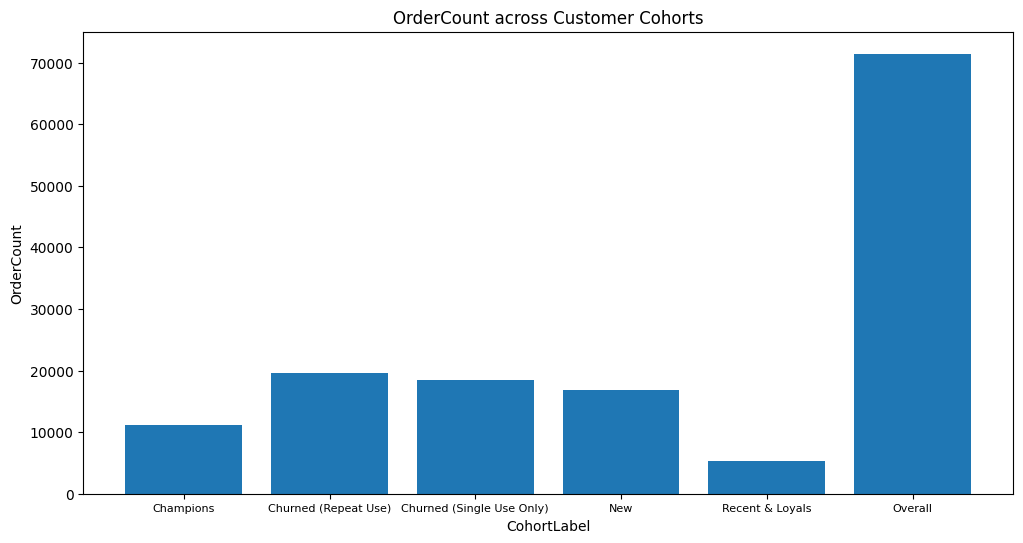

In [24]:
column_to_plot = 'OrderCount'
x_labels = segstats['CohortLabel']
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
plt.bar(x_labels, segstats[column_to_plot])
plt.xlabel('CohortLabel')
plt.ylabel(column_to_plot)
plt.title(f'{column_to_plot} across Customer Cohorts')
plt.xticks(fontsize=8)
plt.show()